In [10]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import pickle
import time

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [11]:
## function to read in the batch files
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin') # encoding latin otherwise no worky
    fo.close()
    return(dict)

In [12]:
def zero_center_pixels(data):
    scale = StandardScaler().fit(data)
    old_mean = scale.mean_.astype('float32')
    old_sigma = np.sqrt(scale.var_).astype('float32')
    return((data - old_mean) * 0.5 / old_sigma)

In [13]:
## read in the data
## manually is easy
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')
label_map = unpickle('cifar-10-batches-py/batches.meta')

In [14]:
## stack up the data batches

## stack up the data batches
all_data = []

for i in data_batch_1['data']:
    all_data.append(i)
    
for i in data_batch_2['data']:
    all_data.append(i)

for i in data_batch_3['data']:
    all_data.append(i)

for i in data_batch_4['data']:
    all_data.append(i)
    
for i in data_batch_5['data']:
    all_data.append(i)

all_data = np.array(all_data)
print(all_data.shape)

(50000, 3072)


In [15]:
## stack up the label data
all_labels = data_batch_1['labels'] + data_batch_2['labels'] + data_batch_3['labels'] + data_batch_4['labels'] + data_batch_5['labels']
all_labels = np.array(all_labels)

test_labels = np.array(test_batch['labels'])

print(all_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


In [16]:
## reshape the image data
all_data_rgb = all_data.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype('float32')
test_data_rgb = test_batch['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('float32')

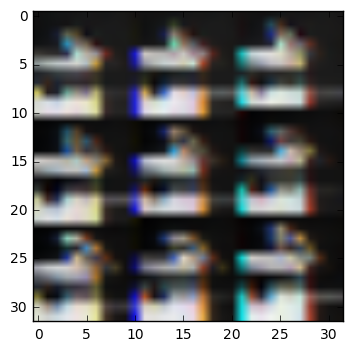

In [17]:
plt.imshow(all_data[13].reshape(32,32,3))
plt.show()

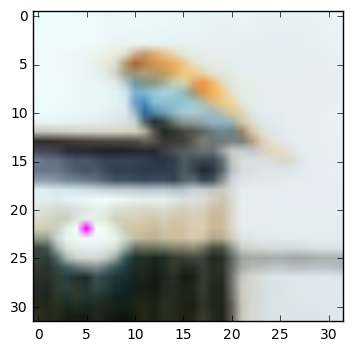

In [18]:
plt.imshow(all_data_rgb[13])
plt.show()

In [19]:
train_dataset = np.array(all_data_rgb)
train_labels = np.array(LabelBinarizer().fit_transform(all_labels))
test_dataset = np.array(test_data_rgb)
test_labels = np.array(LabelBinarizer().fit_transform(test_labels))
print('Train data shape: ', train_dataset.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_dataset.shape)
print('Test labels shape: ', test_labels.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 10)


---
- Step 5 -
============
Convolutional Neural Nets
---------

Now we turn to building a CNN using the architecture described in the TensorFlow website tutorial [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html). It will be a small network with two convolutional layers, followed by one fully connected layer. We'll limit the depth of this model so that it will run fine on the CPU and give a more elaborate architecture below that you can experiment with. Most production CNNs run on GPUs because they require more computation power. You can also find this example explained in Chapter 5 of [First Contact with TensorFlow](http://www.jorditorres.org/first-contact-with-tensorflow/) and in Chapter 5 of "Getting started with TensorFlow" available on [Proquest through Hollis](http://proquest.safaribooksonline.com.ezp-prod1.hul.harvard.edu/book/programming/machine-learning/9781786468574)

### Other useful references
There are also web books: Michael A. Nielsen, [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap6.html) and Goodfellow-et-al [Deep Learning](http://www.deeplearningbook.org/) (which is a preprint, available in HTML). There is also [Colah's blog](http://colah.github.io/) that explains convolutions and has some impressive visualizations. 

If you want to experiment hands-on with convolutions, then download [the GIMP](https://www.gimp.org/downloads/) (if you don't already have it), load up some of your favourite images, and then go to Filters $\rightarrow$ Generic $\rightarrow$ Convolution Matrix.  
[Here](https://docs.gimp.org/en/plug-in-convmatrix.html) are some examples.

---

### Choices to make in a CNN
* convolution kernel dimensions: the patch size (e.g. 5x5)
* stride length: 1, 2, something else
* the padding, SAME or VALID
* pooling: average or max pooling, pooling size  


To make the CNN, we will use two other `nn` functions in TensorFlow. The first is for the convolution itself, called [```tf.nn.conv2d()```](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d) . The function takes a 4D input tensor (hence the reformatting in the previous box), the weight variable and then both the stride and padding are specified as parameters.  

The second function is the pooling function, either [```tf.nn.max_pool```](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#max_pool) or [```tf.nn.avg_pool```](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#avg_pool). These functions take a 4D input tensor, along with the pooling size, the stride and the padding specified as parameters. We will show max_pool in the example.  

Note that between the parameters in convolution and the pooling, we have accumulated a number of hyper-parameters - this gives rise to a large number of options for tuning the best performing model, even without considering regularization/dropout and fully connected layers.

We redefine the weight and bias functions as per the TensorFlow example.

In [20]:
## this code was repurposed from Week 7 Section Jupyter Notebook

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [21]:
## this code was repurposed from Week 7 Section Jupyter Notebook

# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        #test_preds[name] = test_prediction.eval().ravel()

In [22]:
## this code was repurposed from Week 7 Section Jupyter Notebook

image_size = 32
num_labels = 10
num_channels = 3 # RGB
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return(tf.matmul(full3, layer4_weights) + layer4_biases)
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [25]:
## this code was repurposed from Week 7 Section Jupyter Notebook
t0 = time.time()
run_session(100001, "CNN", 0.5)
print(time.time() - t0)

Initialized
Minibatch loss at epoch 0: 2.401806592941284
Minibatch accuracy: 0.0
Minibatch loss at epoch 500: 1.5670338869094849
Minibatch accuracy: 37.5
Minibatch loss at epoch 1000: 1.492214322090149
Minibatch accuracy: 50.0
Minibatch loss at epoch 1500: 0.7120096683502197
Minibatch accuracy: 81.2
Minibatch loss at epoch 2000: 1.39626145362854
Minibatch accuracy: 68.8
Minibatch loss at epoch 2500: 1.7571048736572266
Minibatch accuracy: 37.5
Minibatch loss at epoch 3000: 1.6710104942321777
Minibatch accuracy: 43.8
Minibatch loss at epoch 3500: 1.7399768829345703
Minibatch accuracy: 18.8
Minibatch loss at epoch 4000: 1.2103322744369507
Minibatch accuracy: 43.8
Minibatch loss at epoch 4500: 1.3323168754577637
Minibatch accuracy: 50.0
Minibatch loss at epoch 5000: 0.7991226315498352
Minibatch accuracy: 81.2
Minibatch loss at epoch 5500: 1.6488155126571655
Minibatch accuracy: 43.8
Minibatch loss at epoch 6000: 0.9700036644935608
Minibatch accuracy: 62.5
Minibatch loss at epoch 6500: 0.472